In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import MessagesState,StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from dotenv import load_dotenv
from config import SYSTEM_PROMPT, APIKeysConfig
from custom_tools import *
from user_input import *

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI()

tools=[get_current_weather, get_weather_forecast, get_top_attractions, get_accommodation, convert_currency, get_travel_advisory, estimate_hotel_cost, add_costs, multiply_costs, calculate_total_expense, calculate_daily_budget]
llm_with_tools=llm.bind_tools(tools)

In [3]:
def routing(state: MessagesState):
    query = state["messages"]
    input_question = [SYSTEM_PROMPT] + query
    response_text = llm_with_tools.invoke(input_question)
    return {
        "messages":[response_text]
    }

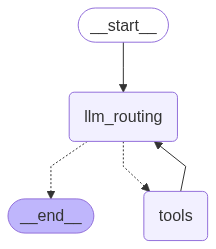

In [4]:
workflow = StateGraph(MessagesState)

workflow.add_node("llm_routing", routing)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "llm_routing")
workflow.add_conditional_edges(
    "llm_routing",
    tools_condition,
)
workflow.add_edge("tools", "llm_routing")
workflow.add_edge("llm_routing", END)


app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [5]:
user_query = ask_user_for_trip_info()

Let's plan your trip! Please answer the following questions.



In [6]:
messages = [HumanMessage(content=f"Plan a trip to with these details: {user_query}")]
response = app.invoke({"messages": messages})

In [7]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Plan a trip to with these details: city=['Berlin'] duration=5 start_date=None end_date=None from_currency='EUR' to_currency='PKR' travelers=1 trip_type='adventure' interests=['nightlife'] accommodation='airbnb' miscellaneous=None
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (call_YZeLMsMLpiAtuoNVNBXvqkeP)
 Call ID: call_YZeLMsMLpiAtuoNVNBXvqkeP
  Args:
    city: Berlin
  get_weather_forecast (call_o5gK0G2ATCUwOMB4u69lX7dV)
 Call ID: call_o5gK0G2ATCUwOMB4u69lX7dV
  Args:
    city: Berlin
  get_top_attractions (call_u0XtcRWwAiHDgFe0iX9wK5HZ)
 Call ID: call_u0XtcRWwAiHDgFe0iX9wK5HZ
  Args:
    city: Berlin
  get_accommodation (call_OLBXMp1Ap2CPOyZwdmg00TIS)
 Call ID: call_OLBXMp1Ap2CPOyZwdmg00TIS
  Args:
    city: Berlin
  get_travel_advisory (call_LTOL11dESwvELNYvJbLAbNDh)
 Call ID: call_LTOL11dESwvELNYvJbLAbNDh
  Args:
    city: Berlin
=